# Regression on California Housing Dataset with `mfnet`

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from matplotlib.ticker import LogFormatter, LogLocator
from sklearn.datasets import fetch_california_housing

from mfnet.dataloader import BatchIterator
from mfnet.layer import Linear, ReLU
from mfnet.loss import MSELoss
from mfnet.nn import NeuralNetwork
from mfnet.tensor import tensor
from mfnet.train import train_test_regression
from mfnet.trainutils import normalize_features, train_test_split


In [ ]:
plt.style.use(
    [
        f"../mplstyles/{style}.mplstyle"
        for style in ["grid", "science", "notebook", "mylegend"]
    ],
)


## Load Data

In [3]:
housing = fetch_california_housing()

housing.target = housing.target.reshape(-1, 1)  # pyright: ignore[reportAttributeAccessIssue]

x = tensor(housing.data)  # pyright: ignore[reportAttributeAccessIssue]
y = tensor(housing.target)  # pyright: ignore[reportAttributeAccessIssue]

In [4]:
x_train, y_train, x_test, y_test = train_test_split(x, y, test_size=0.2)

### Feature normalisation

In [5]:
x_train, y_train, norm = normalize_features(x, y)
x_test, y_test, _ = normalize_features(x_test, y_test, norm)

## Training

In [6]:
NUM_EPOCHS = 500
LEARNING_RATE = 1e-3
BATCH_SIZE = 1024
TEST_INTERVAL = 8
SAVEFIG = True

train_dataloader = BatchIterator(batch_size=BATCH_SIZE, shuffle=True)
train = partial(
    train_test_regression,
    train_inputs=x_train,
    train_targets=y_train,
    test_inputs=x_test,
    test_targets=y_test,
    num_epochs=NUM_EPOCHS,
    test_interval=TEST_INTERVAL,
    lr=LEARNING_RATE,
    dataloader=train_dataloader,
)

### Naive benchmark

In [7]:
target_mean = y_train.mean()

loss = MSELoss()
mean_train_loss = loss.loss(target_mean * np.ones_like(y_train.T), y_train.T)
mean_test_loss = loss.loss(target_mean * np.ones_like(y_test.T), y_test.T)
print(f"Train loss: {mean_train_loss:.4f}, Test loss: {mean_test_loss:.4f}")

Train loss: 1.0000, Test loss: 1.0359


### Shallow linear model benchmark

In [8]:
lin_model = NeuralNetwork([Linear(8, 1)])

lin_train_losses, _, lin_test_losses = train(lin_model)

In [9]:
if lin_test_losses[-1] < mean_test_loss:
    print(
        f"Linear model is better than mean predictor "
        f"({lin_test_losses[-1]:.4f} < {mean_test_loss:.4f})",
    )

Linear model is better than mean predictor (0.4100 < 1.0359)


### Neural Network

In [10]:
nn_model = NeuralNetwork(
    [
        Linear(8, 512),
        ReLU(),
        Linear(512, 512),
        ReLU(),
        Linear(512, 1),
    ],
)

nn_train_losses, _, nn_test_losses = train(nn_model, max_gradient_norm=5.0)

## Plotting

In [11]:
def log_format(ax: Axes) -> None:
    ax.grid(axis="y", which="minor", alpha=0.1)
    ax.set_yscale("log")

    class PlainLogFormatter(LogFormatter):
        def __call__(self, x: float, pos: int | None = None, tol: float = 1e-8) -> str:
            label = super().__call__(x, pos)
            if label == "":
                return ""
            try:
                value = float(x)
                if abs(value - int(value)) < tol:
                    return str(int(value))
                else:  # noqa: RET505
                    return f"{x:.4g}"
            except Exception:  # noqa: BLE001
                return label

    # y-axis ticks
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))
    ax.yaxis.set_major_formatter(LogFormatter())

    ax.yaxis.set_minor_locator(LogLocator(base=10, subs="auto", numticks=10))
    ax.yaxis.set_minor_formatter(PlainLogFormatter(minor_thresholds=(3, 1)))


### Learning Curves

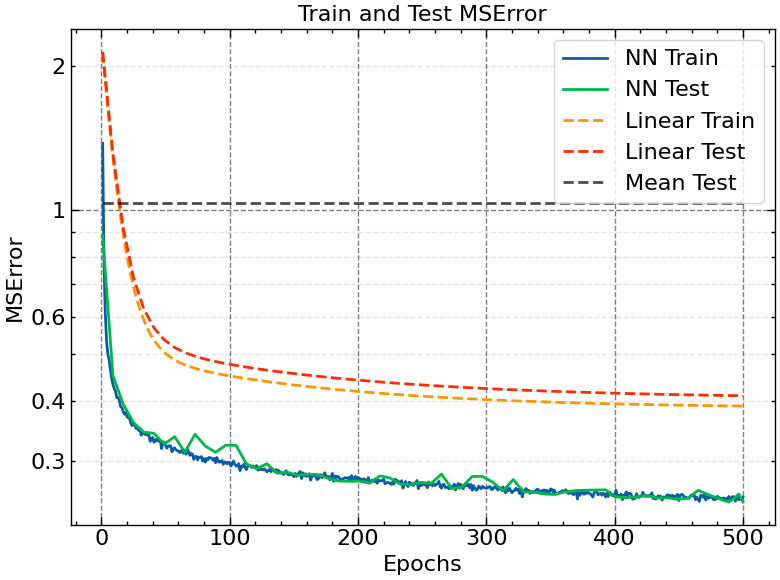

In [16]:
fig, ax = plt.subplots(1, 1)
if TEST_INTERVAL == 1:
    test_epochs = list(range(1, NUM_EPOCHS + 1, TEST_INTERVAL))
else:
    test_epochs = [*list(range(1, NUM_EPOCHS + 1, TEST_INTERVAL)), NUM_EPOCHS]

ax.plot(range(1, NUM_EPOCHS + 1), nn_train_losses, label="NN Train")
ax.plot(test_epochs, nn_test_losses, label="NN Test")
ax.plot(
    range(1, NUM_EPOCHS + 1),
    lin_train_losses,
    label="Linear Train",
    linestyle="--",
)
ax.plot(test_epochs, lin_test_losses, label="Linear Test", linestyle="--")
ax.plot(
    range(1, NUM_EPOCHS + 1),
    mean_test_loss * np.ones_like(nn_train_losses),
    label="Mean Test",
    linestyle="--",
    color="k",
    alpha=0.7,
)

ax.set_title("Train and Test MSError")
ax.set_xlabel("Epochs")
ax.set_ylabel("MSError")

ax.legend()

log_format(ax)

fig.tight_layout()
plt.show()

if SAVEFIG:
    fig.savefig(
        f"./images/mfnet_regr_mserror_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.png",
        dpi=200,
    )